# How to fit tritium measurements

## Data processing

Let's first start with the measurement data. Here we have 7 samples (`LIBRASample`).

Each `LIBRASample` has 4 measurements `LSCSample` (because the bubbler has 4 vials) and a time as a string.

Each `LSCSample` is defined by an activity and a name/label.


In [1]:
from libra_toolbox.tritium import ureg
from libra_toolbox.tritium.lsc_measurements import LSCSample, LIBRASample, GasStream


sample_1 = LIBRASample(
    [
        LSCSample(0.396 * ureg.Bq, "1-1-1"),
        LSCSample(0.375 * ureg.Bq, "1-1-2"),
        LSCSample(4.575 * ureg.Bq, "1-1-3"),
        LSCSample(0.448 * ureg.Bq, "1-1-4"),
    ],
    time="7/29/2024 09:44 PM",
)

sample_2 = LIBRASample(
    [
        LSCSample(0.386 * ureg.Bq, "1-2-1"),
        LSCSample(0.417 * ureg.Bq, "1-2-2"),
        LSCSample(5.659 * ureg.Bq, "1-2-3"),
        LSCSample(0.509 * ureg.Bq, "1-2-4"),
    ],
    time="7/30/2024 09:28 AM",
)

sample_3 = LIBRASample(
    [
        LSCSample(0.393 * ureg.Bq, "1-3-1"),
        LSCSample(0.410 * ureg.Bq, "1-3-2"),
        LSCSample(6.811 * ureg.Bq, "1-3-3"),
        LSCSample(0.492 * ureg.Bq, "1-3-4"),
    ],
    time="7/30/2024 9:59 PM",
)

sample_4 = LIBRASample(
    [
        LSCSample(0.406 * ureg.Bq, "1-4-1"),
        LSCSample(0.403 * ureg.Bq, "1-4-2"),
        LSCSample(4.864 * ureg.Bq, "1-4-3"),
        LSCSample(0.467 * ureg.Bq, "1-4-4"),
    ],
    time="7/31/2024 9:56 AM",
)

sample_5 = LIBRASample(
    [
        LSCSample(0.322 * ureg.Bq, "1-5-1"),
        LSCSample(0.369 * ureg.Bq, "1-5-2"),
        LSCSample(1.900 * ureg.Bq, "1-5-3"),
        LSCSample(0.470 * ureg.Bq, "1-5-4"),
    ],
    time="8/1/2024 11:47 AM",
)

sample_6 = LIBRASample(
    [
        LSCSample(0.343 * ureg.Bq, "1-6-1"),
        LSCSample(0.363 * ureg.Bq, "1-6-2"),
        LSCSample(0.492 * ureg.Bq, "1-6-3"),
        LSCSample(0.361 * ureg.Bq, "1-6-4"),
    ],
    time="8/2/2024 11:24 AM",
)

sample_7 = LIBRASample(
    [
        LSCSample(0.287 * ureg.Bq, "1-7-1"),
        LSCSample(0.367 * ureg.Bq, "1-7-2"),
        LSCSample(0.353 * ureg.Bq, "1-7-3"),
        LSCSample(0.328 * ureg.Bq, "1-7-4"),
    ],
    time="8/4/2024 3:14 PM",
)


All the `LIBRASample` objects are then passed to a `GasStream` class that takes a `start_time` argument as a string.

In [2]:
libra_run = GasStream(
    [sample_1, sample_2, sample_3, sample_4, sample_5, sample_6, sample_7],
    start_time="7/29/2024 9:28 AM",
)

The background activity (measured with a blank sample) is substracted using the `substract_background` method of `LIBRASample`.

.. note::
    We can also use different background LSC samples for different LIBRA samples if need be


In [3]:
background_sample = LSCSample(0.334 * ureg.Bq, "background")

for sample in libra_run.samples:
    sample.substract_background(background_sample)

We can plot the dataset:

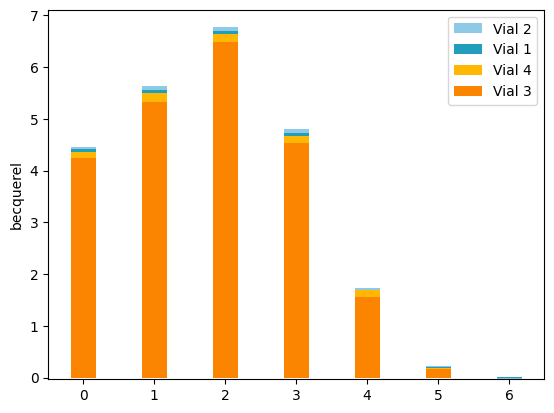

In [4]:
from libra_toolbox.tritium.plotting import plot_bars
import matplotlib.pyplot as plt

plot_bars(libra_run)
plt.legend(reverse=True)
plt.show()

We use `get_cumulative_activity` to compute the cumulative release from these measurements:

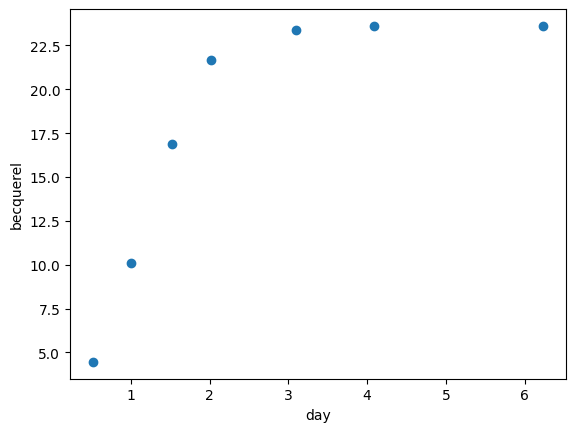

In [5]:
release_measurements = libra_run.get_cumulative_activity(form="total")

plt.scatter(libra_run.relative_times_as_pint, release_measurements)
plt.show()

Now that we have processed our data, we can move on to parametric optimisation.

## Parametric optimisation

In order to perform the parametric optimisation, we need to parametrise the model.
Here the free parameters are $k_\mathrm{top}$ and $k_\mathrm{wall}$.

.. note::
    For details on how to make a tritium release model, see [Tritium release](tritium_model.ipynb)

In [6]:
from libra_toolbox.tritium.model import Model
import numpy as np

P383_neutron_rate = 4.95e8 / 2 * ureg.neutron * ureg.s**-1
A325_neutron_rate = 2.13e8 / 2 * ureg.neutron * ureg.s**-1

baby_diameter = 1.77 * ureg.inches - 2 * 0.06 * ureg.inches  # from CAD drawings
baby_radius = 0.5 * baby_diameter
baby_volume = 100 * ureg.mL
baby_cross_section = np.pi * baby_radius**2
baby_height = baby_volume / baby_cross_section

exposure_time = 12 * ureg.hour

irradiations = [
    [0 * ureg.hour, 0 + exposure_time],
    [24 * ureg.hour, 24 * ureg.hour + exposure_time],
]

def make_model(k_top, k_wall):

    baby_model = Model(
        radius=baby_radius,
        height=baby_height,
        TBR=5.4e-4 * ureg.particle * ureg.neutron**-1,
        k_top=k_top,
        k_wall=k_wall,
        irradiations=irradiations,
        neutron_rate=P383_neutron_rate + A325_neutron_rate,
    )

    return baby_model

We now create an error function that will compute the squared error between the measurements and the values computed by the model:

In [7]:
from libra_toolbox.tritium.model import quantity_to_activity
from scipy.interpolate import interp1d

SCALING_FACTOR_K_TOP = 1e-6
SCALING_FACTOR_K_WALL = 1e-8

all_prms = []
errors = []


def error(prms, verbose=False):
    global all_prms
    global errors
    if verbose:
        print(f"params = {prms}")

    # make the model and run it
    model = make_model(
        k_top=prms[0] * SCALING_FACTOR_K_TOP * ureg.m * ureg.s**-1,
        k_wall=prms[1] * SCALING_FACTOR_K_WALL * ureg.m * ureg.s**-1,
    )

    model.run(7 * ureg.day)

    # compute the error
    computed_release = quantity_to_activity(model.integrated_release_top())
    computed_release_interp = interp1d(
        model.times.to(ureg.day).magnitude, computed_release.to(ureg.Bq).magnitude
    )

    err = 0
    measurements = libra_run.get_cumulative_activity(form="total")

    for time, measurement in zip(libra_run.relative_times_as_pint, measurements):
        # here we need to use .magnitude because the interpolation function does not accept pint quantities
        time = time.to(ureg.day).magnitude
        err += (measurement.to(ureg.Bq).magnitude - computed_release_interp(time)) ** 2

    err *= ureg.Bq**2

    # store the results for later
    all_prms.append(prms)
    errors.append(err.magnitude)

    return err.magnitude

### Using the Neldear-Mead algorithm

We will minimise the `error` function with `scipy.optimize.minimize` with an initial guess.

First we use the Nelder-Mead algorithm.

In [8]:
from scipy.optimize import minimize

initial_guess = [1.6, 5]
res = minimize(error, initial_guess, method="Nelder-Mead")

/home/remidm/miniconda3/envs/libra-toolbox/lib/python3.12/site-packages/scipy/integrate/_ivp/base.py:23: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(fun(t, y), dtype=dtype)


Now that the optimiser has found a minimum, let's plot the results:

Optimised parameters: [1.63987719 4.76387654]


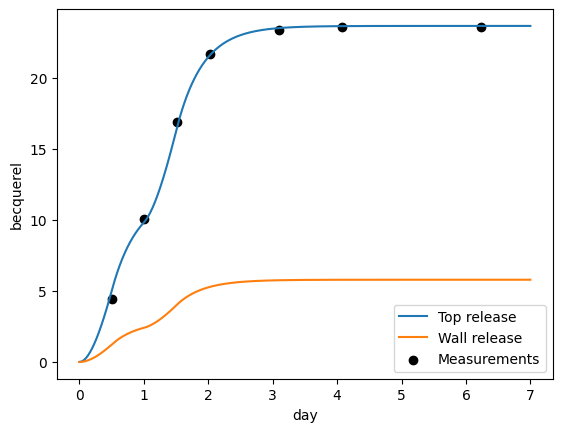

In [9]:
from libra_toolbox.tritium.plotting import (
    plot_integrated_top_release,
    plot_integrated_wall_release,
)

optimised_prms = res.x
print(f"Optimised parameters: {optimised_prms}")

model = make_model(
    k_top=optimised_prms[0] * SCALING_FACTOR_K_TOP * ureg.m * ureg.s**-1,
    k_wall=optimised_prms[1] * SCALING_FACTOR_K_WALL * ureg.m * ureg.s**-1,
)

model.run(7 * ureg.day)

plot_integrated_top_release(model, label="Top release")
plot_integrated_wall_release(model, label="Wall release")
plt.scatter(libra_run.relative_times_as_pint, release_measurements, color="black", label="Measurements")
plt.legend()
plt.show()

We can also show the parameter space:

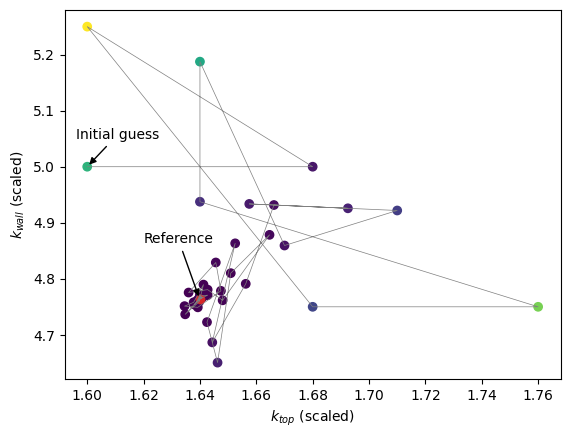

In [10]:
all_prms_array = np.array(all_prms)

plt.scatter(
    all_prms_array[:, 0], all_prms_array[:, 1], c=np.log10(errors), cmap="viridis"
)
plt.plot(all_prms_array[:, 0], all_prms_array[:, 1], color="tab:grey", lw=0.5)

plt.scatter(*optimised_prms, c="tab:red")
plt.annotate(
    "Reference",
    xy=optimised_prms,
    xytext=(optimised_prms[0] - 0.02, optimised_prms[1] + 0.1),
    arrowprops=dict(facecolor="black", arrowstyle="-|>"),
)
plt.annotate(
    "Initial guess",
    xy=initial_guess,
    xytext=(initial_guess[0] - 0.004, initial_guess[1] + 0.05),
    arrowprops=dict(facecolor="black", arrowstyle="-|>"),
)

plt.xlabel(rf"$k_{{top}}$ (scaled)")
plt.ylabel(rf"$k_{{wall}}$ (scaled)")
plt.show()

Finally we show how the error decreased with the number of iterations:

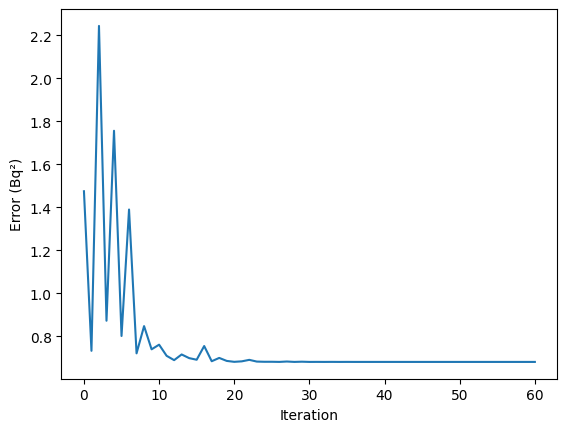

In [11]:
plt.plot(errors)
plt.xlabel("Iteration")
plt.ylabel("Error (Bq²)")
plt.show()

### `scipy.minimize` default algorithm

What would happen if we chose another algorithm? Let's use the default algorithm with the same initial guess.

In [12]:
from scipy.optimize import minimize

initial_guess = [1.6, 5]
res = minimize(error, initial_guess)

/home/remidm/miniconda3/envs/libra-toolbox/lib/python3.12/site-packages/scipy/integrate/_ivp/base.py:23: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(fun(t, y), dtype=dtype)


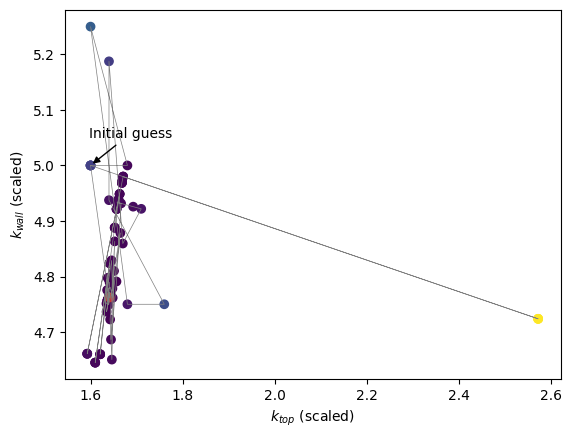

In [13]:
all_prms_array = np.array(all_prms)

plt.scatter(
    all_prms_array[:, 0], all_prms_array[:, 1], c=np.log10(errors), cmap="viridis"
)
plt.plot(all_prms_array[:, 0], all_prms_array[:, 1], color="tab:grey", lw=0.5)

plt.scatter(*optimised_prms, c="tab:red")

plt.annotate(
    "Initial guess",
    xy=initial_guess,
    xytext=(initial_guess[0] - 0.004, initial_guess[1] + 0.05),
    arrowprops=dict(facecolor="black", arrowstyle="-|>"),
)

plt.xlabel(rf"$k_{{top}}$ (scaled)")
plt.ylabel(rf"$k_{{wall}}$ (scaled)")
plt.show()

The algorithm converged towards the same minimum.

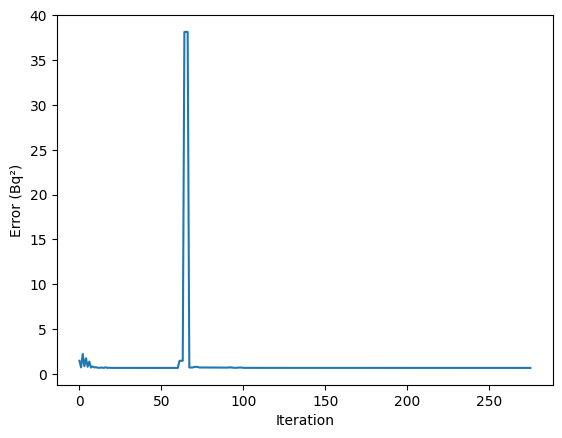

In [14]:
plt.plot(errors)
plt.xlabel("Iteration")
plt.ylabel("Error (Bq²)")
plt.show()

However, it required a lot more iterations (or rather function calls), which is why it took longer to converge.

This is because this algorithm is not derivative free. Nelder-Mead is therefore preferred.

## Comparing sample activity to predictions

It is also possible to compare the measured sample activity to the sample activity predicted by the model (see [LSC sample activity](tritium_model.ipynb#LSC-sample-activity))

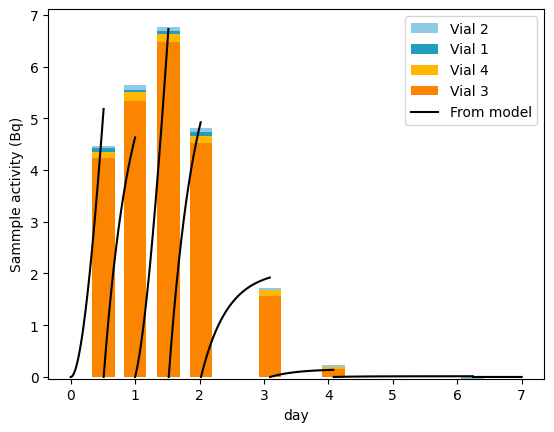

In [15]:
from libra_toolbox.tritium.plotting import plot_sample_activity_top

plot_sample_activity_top(
    model, replacement_times=libra_run.relative_times_as_pint, color="black", label="From model"
)
plot_bars(libra_run, index=libra_run.relative_times_as_pint)

plt.legend(reverse=True)
plt.ylabel("Sammple activity (Bq)")
plt.show()